In [17]:
%matplotlib inline
import matplotlib.pyplot as plt


`Learn the Basics <intro.html>`_ ||
`Quickstart <quickstart_tutorial.html>`_ || 
`Tensors <tensorqs_tutorial.html>`_ || 
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
`Autograd <autogradqs_tutorial.html>`_ ||
**Optimization** ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Optimizing Model Parameters
===========================

Now that we have a model and data it's time to train, validate and test our model by optimizing its parameters on 
our data. Training a model is an iterative process; in each iteration (called an *epoch*) the model makes a guess about the output, calculates 
the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters (as we saw in 
the `previous section  <autograd_tutorial.html>`_), and **optimizes** these parameters using gradient descent. For a more 
detailed walkthrough of this process, check out this video on `backpropagation from 3Blue1Brown <https://www.youtube.com/watch?v=tIeHLnjs5U8>`__.

Prerequisite Code 
-----------------
We load the code from the previous sections on `Datasets & DataLoaders <data_tutorial.html>`_ 
and `Build Model  <buildmodel_tutorial.html>`_.



In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


/Users/woonkiat/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Hyperparameters 
-----------------

Hyperparameters are adjustable parameters that let you control the model optimization process. 
Different hyperparameter values can impact model training and convergence rates 
(`read more <https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html>`__ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




In [3]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

Optimization Loop
-----------------

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each 
iteration of the optimization loop is called an **epoch**. 

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to 
see the `full-impl-label` of the optimization loop.

Loss Function
~~~~~~~~~~~~~~~~~

When presented with some training data, our untrained network is likely not to give the correct 
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value, 
and it is the loss function that we want to minimize during training. To calculate the loss we make a 
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include `nn.MSELoss <https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss>`_ (Mean Square Error) for regression tasks, and 
`nn.NLLLoss <https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss>`_ (Negative Log Likelihood) for classification. 
`nn.CrossEntropyLoss <https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss>`_ combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [4]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

Optimizer
~~~~~~~~~~~~~~~~~

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many `different optimizers <https://pytorch.org/docs/stable/optim.html>`_ 
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.



In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backwards()``. PyTorch deposits the gradients of the loss w.r.t. each parameter. 
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.  



In [6]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Full Implementation
-----------------------
We define ``train_loop`` that loops over our optimization code, and ``test_loop`` that 
evaluates the model's performance against our test data.



In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.



In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.299359  [    0/60000]
loss: 2.295753  [ 6400/60000]
loss: 2.289126  [12800/60000]
loss: 2.293850  [19200/60000]
loss: 2.265240  [25600/60000]
loss: 2.257175  [32000/60000]
loss: 2.252144  [38400/60000]
loss: 2.231548  [44800/60000]
loss: 2.238790  [51200/60000]
loss: 2.229231  [57600/60000]
Test Error: 
 Accuracy: 44.8%, Avg loss: 0.034881 

Epoch 2
-------------------------------
loss: 2.213576  [    0/60000]
loss: 2.212882  [ 6400/60000]
loss: 2.185851  [12800/60000]
loss: 2.211651  [19200/60000]
loss: 2.153326  [25600/60000]
loss: 2.116789  [32000/60000]
loss: 2.150626  [38400/60000]
loss: 2.090351  [44800/60000]
loss: 2.113914  [51200/60000]
loss: 2.091846  [57600/60000]
Test Error: 
 Accuracy: 48.8%, Avg loss: 0.032695 

Epoch 3
-------------------------------
loss: 2.074331  [    0/60000]
loss: 2.063243  [ 6400/60000]
loss: 2.009751  [12800/60000]
loss: 2.075648  [19200/60000]
loss: 1.955205  [25600/60000]
loss: 1.893468  [32000/600

In [9]:
torch.save(model, 'model.pth')

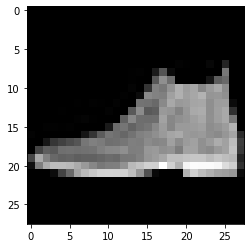

In [18]:
img = test_dataloader.dataset[0][0].squeeze()

plt.imshow(img, cmap="gray")

In [44]:
model = torch.load('model.pth')

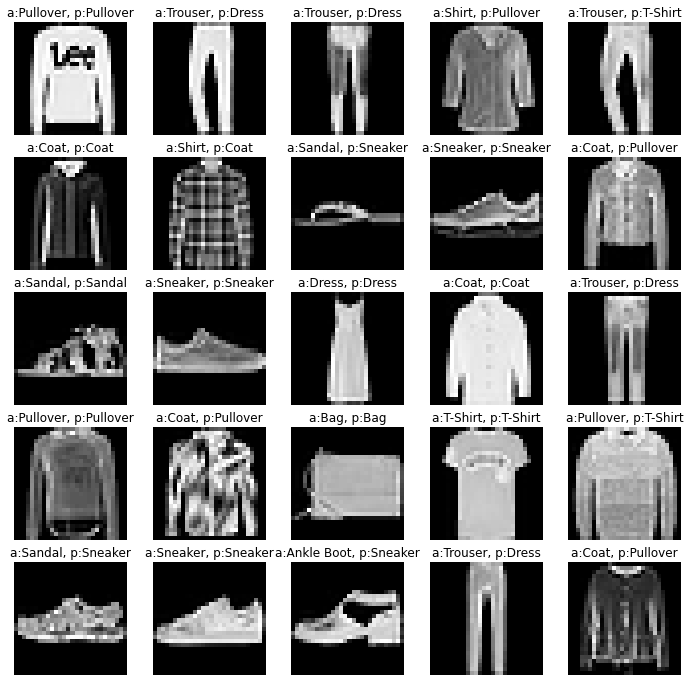

In [47]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(12, 12))
cols, rows = 5, 5

with torch.no_grad():
    for i in range(1, cols * rows + 1):
        pred = model(test_dataloader.dataset[i][0]).argmax(1).item()
        y = test_dataloader.dataset[i][1]
        
        img = test_dataloader.dataset[i][0].squeeze()
        figure.add_subplot(rows, cols, i)
        plt.title('a:{}, p:{}'.format(labels_map[y],labels_map[pred]))
        plt.axis("off")
        plt.imshow(img, cmap="gray")


Further Reading
-----------------------
- `Loss Functions <https://pytorch.org/docs/stable/nn.html#loss-functions>`_
- `torch.optim <https://pytorch.org/docs/stable/optim.html>`_
- `Warmstart Training a Model <https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html>`_


